# 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import my_functions as mf
np.random.seed(22)

In [3]:
df = pd.read_csv('Greece_Yields.csv').drop(columns = ['Date'])
len(df)

51

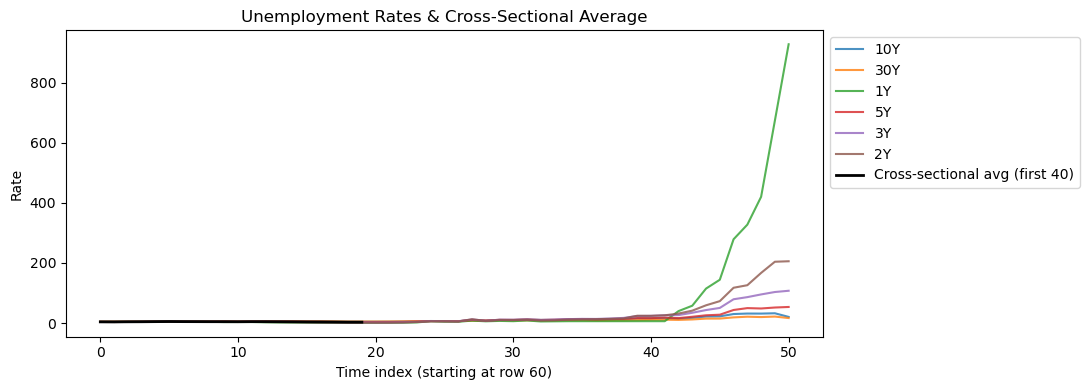

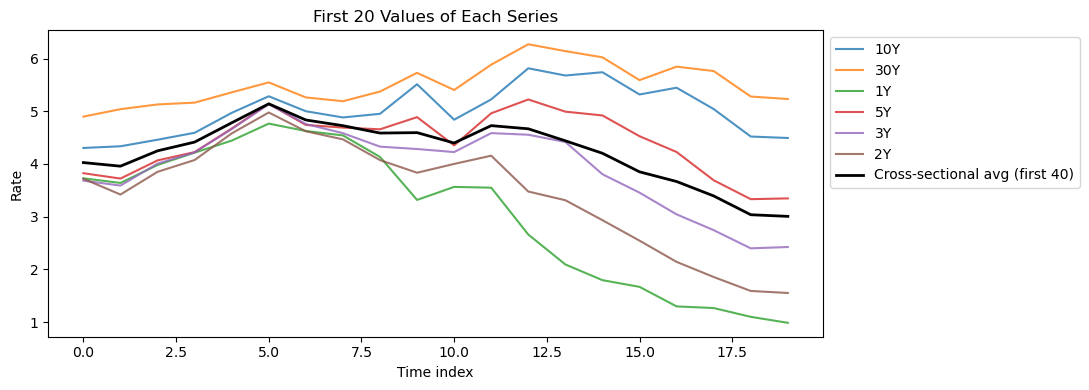

In [4]:
df2 = df.copy() 
avg40 = df2.iloc[:20].mean(axis=1)

X = sm.add_constant(avg40)
betas = []
for col in df2.columns:
    y40 = df2[col].iloc[:20]
    model = sm.OLS(y40, X).fit()
    betas.append(model.params[1:])        
    
betas = np.round(np.array(betas), 3)           
# print("Betas:", betas)
# print("Shape:", betas.shape)

plt.figure(figsize=(11,4))

for col in df2.columns:
    plt.plot(df2.index, df2[col], alpha=0.8, label=col)
plt.plot(
    avg40.index, avg40,
    color='black', lw=2,
    label='Cross‐sectional avg (first 40)'
)

plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title("Unemployment Rates & Cross-Sectional Average")
plt.xlabel("Time index (starting at row 60)")
plt.ylabel("Rate")
plt.tight_layout()
plt.show()


n = 20  # you can change this to any number you like

plt.figure(figsize=(11,4))
for col in df2.columns:
    plt.plot(df2.index[:n], df2[col].iloc[:n], alpha=0.8, label=col)
plt.plot(
    avg40.index, avg40,
    color='black', lw=2,
    label='Cross‐sectional avg (first 40)'
)
    
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title(f"First {n} Values of Each Series")
plt.xlabel("Time index")
plt.ylabel("Rate")
plt.tight_layout()
plt.show()

In [5]:
df = df2.copy()

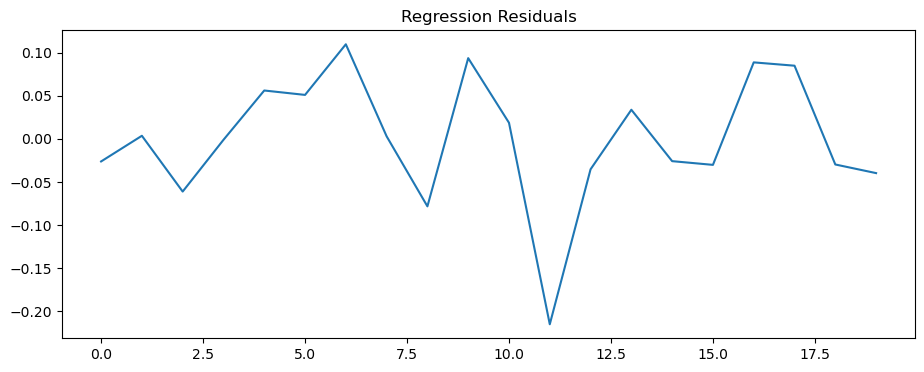

ADF Statistic: -12.42864116476653
p-value: 3.9862015036015616e-23
Result: The time series is STATIONARY (reject null of unit root).


In [49]:
df = np.array(df)
plt.figure(figsize=(11,4))

Y = df[:20, 0]
X = df[:20, 1:]
X_const = sm.add_constant(X)
model = sm.OLS(Y, X_const)
results = model.fit()
params = results.params
a = params[0]  # Intercept
b = params[1:] # All slopes
pre_resid = Y - (a + X @ b)
plt.plot(pre_resid)
plt.title("Regression Residuals")
plt.show()

# ADF test on residuals
adf_statistic, p_value, _, _, critical_values, _ = adfuller(pre_resid)

print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")

# Determine stationarity
alpha = 0.05  # significance level (5%)
if p_value < alpha:
    print("Result: The time series is STATIONARY (reject null of unit root).")
else:
    print("Result: The time series is NON-STATIONARY (fail to reject null of unit root).")

Y = df[20:, 0]
X = df[20:, 1:]
post_resid = Y - (a + X @ b)

Running Simulations: |██████████████████████████████| 100% --- 2000/2000

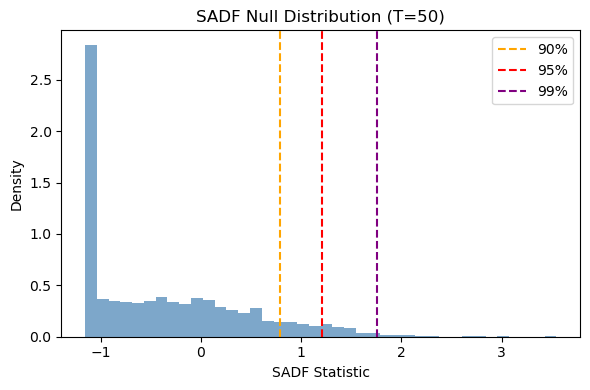

     Critical Value
90%        0.792617
95%        1.207539
99%        1.754598




In [8]:
num_series = 6
T = 50
z = mf.random_walk(1000).reshape(-1, 1) #constant
eps = np.random.normal(0, 1, size=(1000, num_series)) # DEPENDS on T
et = np.random.normal(0, 1, size=(1000, num_series)) #constant
e = eps[:T,:].copy()
common_fac = z[:T].copy()

B = 2000
multipliers = betas.squeeze()


e = eps[:T,:].copy()
common_fac = z[:T].copy()

num_of_rw = 0.6
coint_frac = 0.5
innov_8 = np.random.normal(0, 1, size=(T - int(T * coint_frac), int(num_of_rw * num_series))) #constant

innov = innov_8
crit_val = mf.simulate_sadf_distribution_gpu(B=B, T=T, num_series=num_series, coint_frac=coint_frac, num_of_rw=num_of_rw, multi = multipliers, common_fac = common_fac, e = e)
print(crit_val)
crit_val_95 = np.round(crit_val.loc["95%", "Critical Value"],3)
crit_val_99 = np.round(crit_val.loc["99%", "Critical Value"],3)

print("\n")

# """ Run Experiment """
# mf.run_sadf_bubble_check( delta, T, coint_frac, num_of_rw,  common_fac, multipliers, innov, e, crit_val_95, crit_val_99, num_series)
# print("Multipliers:", multipliers)

Running Simulations: |██████████████████████████████| 100% --- 2000/2000

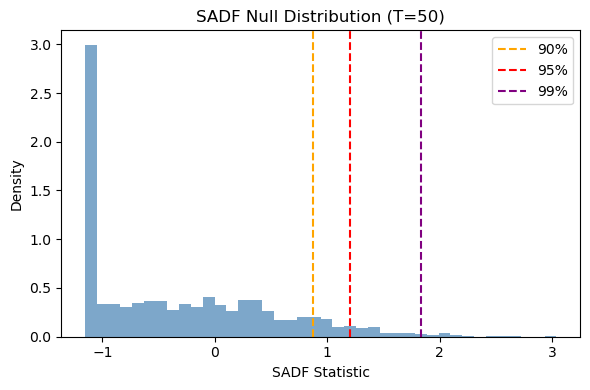

     Critical Value
90%        0.875087
95%        1.203262
99%        1.834527




In [9]:
num_series = 6

T = 50
e = eps[:T,:].copy()
common_fac = z[:T].copy()

num_of_rw = 0.4
coint_frac = 0.5
innov_8 = np.random.normal(0, 1, size=(T - int(T * coint_frac), int(num_of_rw * num_series))) #constant

crit_val = mf.simulate_sadf_distribution_gpu(B=B, T=T, num_series=num_series, coint_frac=coint_frac, num_of_rw=num_of_rw, multi = multipliers, common_fac = common_fac, e = e)
print(crit_val)
crit_val_95_40 = np.round(crit_val.loc["95%", "Critical Value"],3)
crit_val_99_40 = np.round(crit_val.loc["99%", "Critical Value"],3)

print("\n")



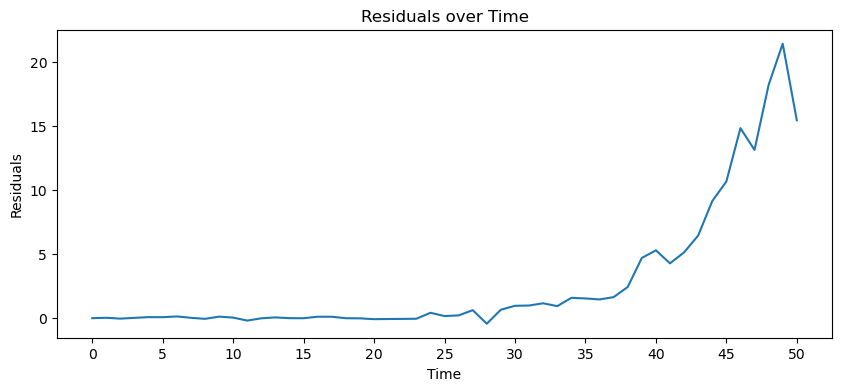

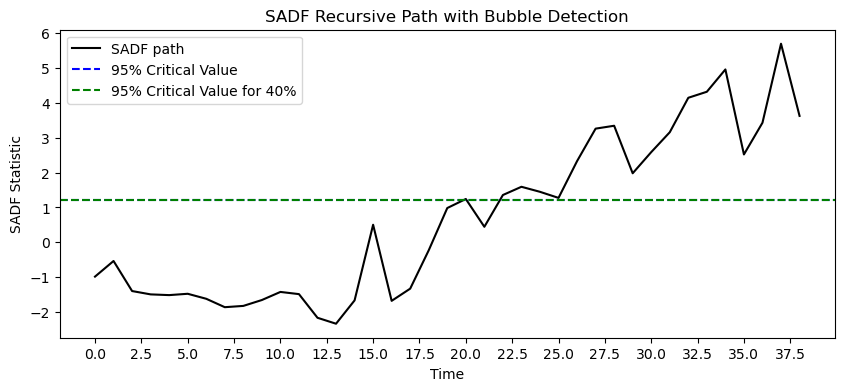

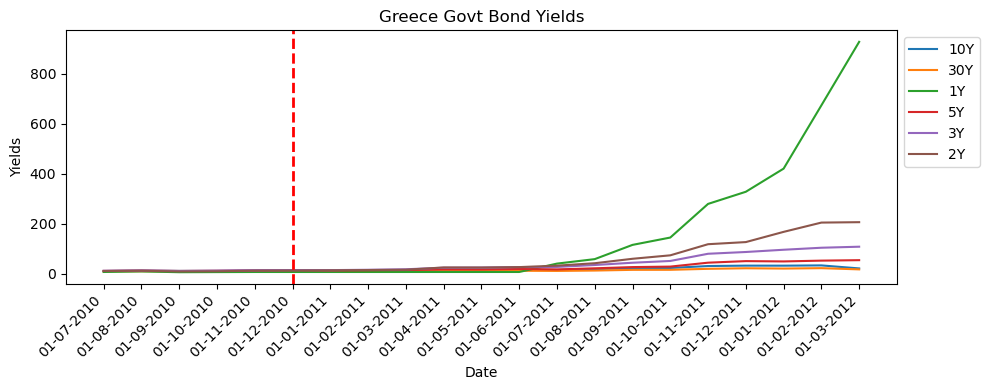

In [47]:
resid = np.concatenate([pre_resid,post_resid])
plt.figure(figsize=(10, 4))
plt.plot(resid)
plt.title("Residuals over Time")
plt.xlabel("Time")
plt.ylabel("Residuals")
# Increase number of x-ticks for the residuals plot
plt.locator_params(axis='x', nbins=20)
plt.show()

# Calculate minimum window and SADF series
min_win = int((0.01 + 1.8 / np.sqrt(T)) * T)
sadf_stats = mf.sadf_series(resid, min_win)

# Plot SADF path with shaded bubble window
plt.figure(figsize=(10, 4))
plt.plot(sadf_stats, label='SADF path', color='black')
plt.axhline(crit_val_95, color='blue', linestyle='--', label='95% Critical Value')
#plt.axhline(crit_val_99, color='red', linestyle='--', label='99% Critical Value')
plt.axhline(crit_val_95_40, color='green', linestyle='--', label='95% Critical Value for 40%')
#plt.axhline(crit_val_99_40, color='magenta', linestyle='--', label='99% Critical Value for 40%')

# Highlight the window where the statistic first exceeds the 95% critical value
for t, stat in enumerate(sadf_stats):
    if stat > crit_val_95 + 0.1:
        start = t-1
        end = t + min_win
        # plt.axvspan(start, end, color='orange', alpha=0.3, label='Bubble window')
        break

plt.title("SADF Recursive Path with Bubble Detection")
plt.xlabel("Time")
plt.ylabel("SADF Statistic")
plt.legend()
# Increase number of x-ticks for better readability
plt.locator_params(axis='x', nbins=20)
plt.show()


data = pd.read_csv('Greece_Yields.csv')

# Keep Date column as strings
date_local = data['Date'].copy()
yields = data.drop(columns=['Date'])

# Create a numeric x‐axis (just the integer index)
x = np.arange(len(data))

plt.figure(figsize=(10, 4))

# Plot each series against its integer index (starting at 20)
for col in yields.columns:
    plt.plot(x[30:], yields[col].iloc[30:], label=col)

# Show around 20 ticks, using the date strings as labels
tick_positions = x[30:: max(1, (len(x)-30)//30)]
tick_labels    = date_local.iloc[30:: max(1, (len(x)-30)//30)]
plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')

# Vertical line at t_local (must be defined earlier)
t_local = t + min_win
plt.axvline(t_local, color='red', linestyle='--', linewidth=2)

plt.title("Greece Govt Bond Yields")
plt.xlabel("Date")
plt.ylabel("Yields")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()